Purpose
===
Existing gene categories in DGIdb will not necessarily match new gene category sources, such as the IUPPHAR/BPS *Guide To Pharmacology*. Also, category scope will necessarily be different between some current DGIdb categories and any given categorization by a single new resource. This program describes our attempt to reconcile this in selecting new categories for the DGIdb.

Python Environment
===

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import csv
from matplotlib_venn import venn2
from collections import defaultdict
def dd(obj, nest=1):
    if nest > 1:
        return defaultdict(lambda: dd(obj, nest-1))
    else:
        return defaultdict(obj)

Mapping Guide to Pharmacology to Existing Categories
===
Load gene categories and associated genes.
Categories are manually extracted from PostgreSQL and hard-coded.
Categories from GO only are excluded.
Druggable Genome is excluded.
Clinically Actionable is excluded.
Genes are pulled from DGIdb via API.

In [2]:
categories = [
                "ABC TRANSPORTER",
                "B30_2 SPRY DOMAIN",
                "CYTOCHROME P450",
                "DNA DIRECTED RNA POLYMERASE",
                "EXCHANGER",
                "FIBRINOGEN",
                "G PROTEIN COUPLED RECEPTOR",
                "ION CHANNEL",
                "KINASE",
                "LIPASE",
                "METHYL TRANSFERASE",
                "MYOTUBULARIN RELATED PROTEIN PHOSPHATASE",
                "NEUTRAL ZINC METALLOPEPTIDASE",
                "NUCLEAR HORMONE RECEPTOR",
                "PHOSPHATIDYLINOSITOL 3 KINASE",
                "PHOSPHOLIPASE",
                "PROTEASE",
                "PROTEASE INHIBITOR",
                "PROTEIN PHOSPHATASE",
                "PTEN FAMILY",
                "SERINE THREONINE KINASE",
                "SHORT CHAIN DEHYDROGENASE REDUCTASE",
                "THIOREDOXIN",
                "TRANSPORTER",
                "TYROSINE KINASE"
             ]
genes = {}
request = "http://dgidb.genome.wustl.edu/api/v1/genes_in_category.json?category="
for category in categories:
    response = requests.get(request + category.lower())
    genes[category] = response.text.strip('][').replace('"','').split(',')
    if not all (genes[category]):
        raise ValueError (category, sorted(genes[category]))
        
with open('targets_and_families.4_mar.2015.csv') as csvfile:
    # Initialize reader
    target_families = csv.DictReader(csvfile)
    
    # Initialize dictionaries / counters
    family_members = dd(set)
    gtp_genes = set()
    category_family_count = dd(int, 2)
    gene_family_count     = dd(int, 2)
    family_type = {}
    
    # Define Searchable Fields (from file header)
    search_attributes = ['Type','Family name', 'Target name', 
                         'synonyms', 'HGNC name']
    
    # Evaluate each row for matches
    for row_dict in target_families:
        gene_symbol = row_dict['HGNC symbol']
        gene_family = row_dict['Family name']
        gene_type   = row_dict['Type']
        family_members[gene_family].add(gene_symbol)
        family_members[gene_type + ' [type]'].add(gene_symbol)
        family_type[gene_family] = gene_type + ' [type]'
        gtp_genes.add(gene_symbol)
        for category in categories:
            
            # Category gene symbol matching
            if gene_symbol in genes[category]:
                gene_family_count[category][gene_family] += 1
                gene_family_count[category][gene_type + ' [type]'] += 1
                
            # Category name matching
            search_fields = [ row_dict[x].lower() for x in search_attributes ]
            if any([ category.lower() in x for x in search_fields ]):
                category_family_count[category][gene_family] += 1
                category_family_count[category][gene_type + ' [type]'] += 1

Initial Category Name Matches
---
First, how did exact string matching of DGIdb categories to gene/target descriptions perform?

In [3]:
# Pretty formatting for category match header output
def print_cat_header(category_family_count, header):
    category_length = max([len(x) for x in category_family_count])
    fstring     = '{0:{length}}  {1:16}  {2}'
    fstring_row = '{0:{length}}  {1:4}/{2:4} ({3:3}%)  {4}' 
    print(header)
    print('=' * len(header))
    out = fstring.format('Category','Matches','Family/Type', 
                         length=category_length)
    print(out + "\n" + '-' * len(out))
    return fstring_row

# Pretty formatting for category match output
def print_match(fstring_row, category_family_count, head=None):
    i = 0
    j = 0
    category_length = max([len(x) for x in category_family_count])
    for category in sorted(category_family_count):
        for family in sorted(category_family_count[category]):
            if head is not None and i == head:
                j+=1
                continue
            else:
                i+=1
            observed = category_family_count[category][family]
            total = len(family_members[family])
            percentage = round(observed/total*100)
            print(fstring_row.format(category, observed, 
                                     total, percentage, family, 
                                     length=category_length))
    if j > 0:
        print('... ({0} additional records)'.format(j))
    
fstring_row = print_cat_header(category_family_count, 
                               'DGIdb category name matches')
print_match(fstring_row, category_family_count, head=10)

DGIdb category name matches
Category                    Matches           Family/Type
---------------------------------------------------------
ABC TRANSPORTER                1/  12 (  8%)  ABCA subfamily
ABC TRANSPORTER                5/  11 ( 45%)  ABCB subfamily
ABC TRANSPORTER                3/   3 (100%)  ABCD subfamily of peroxisomal ABC transporters
ABC TRANSPORTER                1/   5 ( 20%)  ABCG subfamily
ABC TRANSPORTER               10/ 507 (  2%)  transporter [type]
CYTOCHROME P450                3/   3 (100%)  CYP1 family
CYTOCHROME P450                7/   7 (100%)  CYP11, CYP17, CYP19, CYP20 and CYP21 families
CYTOCHROME P450               16/  16 (100%)  CYP2 family
CYTOCHROME P450                7/   7 (100%)  CYP24, CYP26 and CYP27 families
CYTOCHROME P450                4/   4 (100%)  CYP3 family
... (446 additional records)


It appears that a number of these direct matches have 100% of the family members in the DGIdb category. These make for good initial keys in a `GuideToPharmacology -> DGIdb category` mapping.

In [4]:
dgidb_category_map = dd(set)

def map_and_get_remainder(dict_of_counts):
    remainder = dd(int, 2)
    for category in sorted(dict_of_counts):
        for family in sorted(dict_of_counts[category]):
            observed = dict_of_counts[category][family]
            total = len(family_members[family])
            if observed == total:
                dgidb_category_map[family].add(category)
            else:
                remainder[category][family] = observed
    return remainder

category_remainder = map_and_get_remainder(category_family_count)

def print_reduction(initial, remainder, header=''):
    if header:
        print(header)
    initial_length   = sum([ len(initial[category]) 
                            for category in initial ])
    remainder_length = sum([ len(remainder[category]) 
                            for category in remainder ])
    out = 'Total matches: {0}  Incomplete matches: {1}'
    print(out.format(initial_length, remainder_length))
    
print_reduction(category_family_count, category_remainder)

Total matches: 456  Incomplete matches: 103


That really reduced the size of the list! Before we start manually reviewing, though, we should see if we can knock a few of these out through gene matching.

Initial Gene to Category Mapping
---
First, a look at how the gene symbols from the DGIdb categories mapped to Guide To Pharmacology.

In [5]:
fstring_row = print_cat_header(gene_family_count, 
                               'DGIdb category genes mapping')
print_match(fstring_row, gene_family_count, head=10)

DGIdb category genes mapping
Category                             Matches           Family/Type
------------------------------------------------------------------
ABC TRANSPORTER                         4/  12 ( 33%)  ABCA subfamily
ABC TRANSPORTER                        11/  11 (100%)  ABCB subfamily
ABC TRANSPORTER                        11/  11 (100%)  ABCC subfamily
ABC TRANSPORTER                         2/   3 ( 67%)  ABCD subfamily of peroxisomal ABC transporters
ABC TRANSPORTER                         2/   5 ( 40%)  ABCG subfamily
ABC TRANSPORTER                         1/   1 (100%)  CFTR
ABC TRANSPORTER                         9/   9 (100%)  Ca<sup>2+</sup>-ATPases
ABC TRANSPORTER                         2/   2 (100%)  Cu<sup>+</sup>-ATPases
ABC TRANSPORTER                         5/  14 ( 36%)  F-type ATPase
ABC TRANSPORTER                         3/   3 (100%)  H<sup>+</sup>/K<sup>+</sup>-ATPases
... (897 additional records)


Again, a rather extensive list. Let's pare it down with the same 100% auto-mapping strategy.

In [6]:
gene_remainder = map_and_get_remainder(gene_family_count)
print_reduction(gene_family_count, gene_remainder)

Total matches: 907  Incomplete matches: 244


Better, but still a number of incomplete matches to review.

Reciprocal Filtering
---
Let's use our mapping from both categories to reduce the remaining partial family matches.

In [7]:
def mapped(family, category):
    return family in dgidb_category_map and category in dgidb_category_map[family]

def remove_mapped(dict_of_counts):
    remainder = dd(dict)
    for category in dict_of_counts:
        for family in dict_of_counts[category]:
            if not mapped(family, category): 
                if family.endswith('[type]'):
                    remainder[category][family] = dict_of_counts[category][family]
                elif not mapped(family_type[family], category):
                    remainder[category][family] = dict_of_counts[category][family]
    return remainder

gene_remainder_filtered = remove_mapped(gene_remainder)
category_remainder_filtered = remove_mapped(category_remainder)

def print_totals():
    print_reduction(category_family_count, 
                    category_remainder_filtered, 
                    "Category matches:")
    print_reduction(gene_family_count, 
                    gene_remainder_filtered, 
                    "Gene matches:")
    observed = len(dgidb_category_map)
    total = len(family_members)
    out = 'Total family mappings: {0}/{1} ({2}%)'
    print(out.format(observed,total,round(observed/total*100)))
    obs_g = set()
    for f, gs in family_members.items():
        if f in dgidb_category_map:
            for g in gs:
                obs_g.add(g)
    total = len(gtp_genes)
    observed = len(obs_g)
    out = 'Total genes mapped at least once: {0}/{1} ({2}%)'
    print(out.format(observed,total,round(observed/total*100)))
            
print_totals()

Category matches:
Total matches: 456  Incomplete matches: 70
Gene matches:
Total matches: 907  Incomplete matches: 212
Total family mappings: 452/573 (79%)
Total genes mapped at least once: 1900/2712 (70%)


It looks like this is as small as it gets. 80% of families map to at least one existing category with the default rules. Nice!

Manual Review
---
Here's where it gets messy.

###Review of Category Name Matching
First, evaluation of partial family matches by category name.

In [8]:
fstring_row = print_cat_header(category_remainder_filtered,
                               'DGIdb category matches, after filtering')
print_match(fstring_row, category_remainder_filtered)

DGIdb category matches, after filtering
Category                    Matches           Family/Type
---------------------------------------------------------
ABC TRANSPORTER                1/  12 (  8%)  ABCA subfamily
ABC TRANSPORTER                1/   5 ( 20%)  ABCG subfamily
ABC TRANSPORTER               10/ 507 (  2%)  transporter [type]
CYTOCHROME P450                2/  10 ( 20%)  Prostaglandin synthases
CYTOCHROME P450               59/1140 (  5%)  enzyme [type]
EXCHANGER                      2/   3 ( 67%)  SLC19 family of vitamin transporters
EXCHANGER                      1/   3 ( 33%)  SLC34 family of sodium phosphate co-transporters
EXCHANGER                      1/  13 (  8%)  SLC7 family
EXCHANGER                      3/   6 ( 50%)  Sodium-dependent HCO<sub>3</sub><sup>-</sup> transporters
EXCHANGER                     49/ 507 ( 10%)  transporter [type]
FIBRINOGEN                     1/  27 (  4%)  Integrins
FIBRINOGEN                     1/ 241 (  0%)  catalytic_receptor [

###Manual Review Mappings for Category Name Matching:
* [ABCA and ABCG subfamilies](http://www.ncbi.nlm.nih.gov/books/NBK3/) to the ABC TRANSPORTER category.
* [SLC19](http://www.ncbi.nlm.nih.gov/pubmed/14770311) to the EXCHANGER category.
* gpcr [type] to the G PROTEIN COUPLED RECEPTOR category.
* lgic [type] to the ION CHANNEL category.
* other_ic [type] to the ION CHANNEL category.
* nhr [type] to the NUCLEAR HORMONE RECEPTOR category.

In [9]:
def cmap(family, category):
    return dgidb_category_map[family].add(category)

cmap('ABCA subfamily','ABC TRANSPORTER')
cmap('ABCG subfamily','ABC TRANSPORTER')
cmap('SLC19 family of vitamin transporters','EXCHANGER')
cmap('gpcr [type]','G PROTEIN COUPLED RECEPTOR')
cmap('lgic [type]','ION CHANNEL')
cmap('other_ic [type]','ION CHANNEL')
cmap('nhr [type]','NUCLEAR HORMONE RECEPTOR')

In [10]:
gene_remainder_filtered = remove_mapped(gene_remainder)
category_remainder_filtered = remove_mapped(category_remainder)
print_totals()

Category matches:
Total matches: 456  Incomplete matches: 59
Gene matches:
Total matches: 907  Incomplete matches: 189
Total family mappings: 456/573 (80%)
Total genes mapped at least once: 2105/2712 (78%)


Mapping the types to their respective categories bolstered the at-least-one gene mapping by 8 percentage points!

###Manual Review of Gene to Category Mapping
Next, evaluation of partial matches by gene membership.

In [11]:
fstring_row = print_cat_header(gene_remainder_filtered, 
                               'DGIdb category gene mapping, after filtering')
print_match(fstring_row, gene_remainder_filtered)

DGIdb category gene mapping, after filtering
Category                             Matches           Family/Type
------------------------------------------------------------------
ABC TRANSPORTER                         5/  14 ( 36%)  F-type ATPase
ABC TRANSPORTER                        14/  23 ( 61%)  V-type ATPase
ABC TRANSPORTER                         1/  48 (  2%)  other_ic [type]
ABC TRANSPORTER                        85/ 507 ( 17%)  transporter [type]
B30_2 SPRY DOMAIN                       3/  85 (  4%)  lgic [type]
CYTOCHROME P450                         2/  10 ( 20%)  Prostaglandin synthases
CYTOCHROME P450                        59/1140 (  5%)  enzyme [type]
EXCHANGER                              13/ 507 (  3%)  transporter [type]
G PROTEIN COUPLED RECEPTOR              1/   3 ( 33%)  1C. Peroxisome proliferator-activated receptors
G PROTEIN COUPLED RECEPTOR              1/   3 ( 33%)  1F. Retinoic acid-related orphans
G PROTEIN COUPLED RECEPTOR              2/   6 ( 33%)  5-

###Manual Review Mappings for Gene to Category Mapping
* 2.1.1.- Protein arginine N-methyltransferases to METHYL TRANSFERASE
* 2.1.1.43 Histone methyltransferases (HMTs) to METHYL TRANSFERASE
* [M14](http://en.wikipedia.org/wiki/Carboxypeptidase_A), [M1](http://en.wikipedia.org/wiki/Alanine_aminopeptidase), [M28](http://www.ncbi.nlm.nih.gov/pubmed/8175799), and [M2](http://www.ncbi.nlm.nih.gov/pubmed/16054014) to NEUTRAL ZINC METALLOPEPTIDASE
* [C1: Papain](http://www.guidetopharmacology.org/GRAC/FamilyDisplayForward?familyId=728) to PROTEASE
* [M1: Alanine aminopeptidase](http://en.wikipedia.org/wiki/Alanine_aminopeptidase) to PROTEASE
* [AMPK subfamily](http://www.ncbi.nlm.nih.gov/pubmed/9136115) to SERINE THREONINE KINASE
* [CAMK2 family](http://en.wikipedia.org/wiki/Ca2%2B/calmodulin-dependent_protein_kinase_II) to SERINE THREONINE KINASE
* [Casein kinase 2 (CK2) family](http://en.wikipedia.org/wiki/Casein_kinase_2) to SERINE THREONINE KINASE
* [Protein kinase A](http://en.wikipedia.org/wiki/Protein_kinase_A) to SERINE THREONINE KINASE
* [5-HT<sub>3</sub> receptors](http://www.guidetopharmacology.org/GRAC/FamilyIntroductionForward?familyId=68) to TRANSPORTER
* [Transient Receptor Potential channels](http://www.guidetopharmacology.org/GRAC/FamilyDisplayForward?familyId=78) to TRANSPORTER
* [Fatty acid-binding proteins](http://www.guidetopharmacology.org/GRAC/FamilyDisplayForward?familyId=783) to TRANSPORTER
* lgic [type], vgic [type], and other_ic[type] to TRANSPORTER

*Notably*, the M\d+: identifier shows various metallopeptidase families, most of which are zinc based. There is no "Neutral Zinc Metallopeptidase" annotation in GO, nor in the Hopkins/Groom resource from DGIdb (the two resources with genes in this category). However, there is documentation of such a group at [prosite](http://prosite.expasy.org/PDOC00129), so I'm assuming there was good reason for naming it this.

In [12]:
cmap('2.1.1.- Protein arginine N-methyltransferases','METHYL TRANSFERASE')
cmap('2.1.1.43 Histone methyltransferases (HMTs)','METHYL TRANSFERASE')
cmap('M14: Carboxypeptidase A','NEUTRAL ZINC METALLOPEPTIDASE')
cmap('M1: Aminopeptidase N','NEUTRAL ZINC METALLOPEPTIDASE')
cmap('M28: Aminopeptidase Y','NEUTRAL ZINC METALLOPEPTIDASE')
cmap('M2: Angiotensin-converting  (ACE and ACE2)','NEUTRAL ZINC METALLOPEPTIDASE')
cmap('C1: Papain','PROTEASE')
cmap('M1: Aminopeptidase N','PROTEASE')
cmap('AMPK subfamily','SERINE THREONINE KINASE')
cmap('CAMK2 family','SERINE THREONINE KINASE')
cmap('Casein kinase 2 (CK2) family','SERINE THREONINE KINASE')
cmap('Protein kinase A','SERINE THREONINE KINASE')
cmap('5-HT<sub>3</sub> receptors','TRANSPORTER')
cmap('Transient Receptor Potential channels','TRANSPORTER')
cmap('Fatty acid-binding proteins','TRANSPORTER')
cmap('lgic [type]','TRANSPORTER')
cmap('vgic [type]','TRANSPORTER')
cmap('other_ic [type]', 'TRANSPORTER')

In [13]:
gene_remainder_filtered = remove_mapped(gene_remainder)
category_remainder_filtered = remove_mapped(category_remainder)
print_totals()

Category matches:
Total matches: 456  Incomplete matches: 56
Gene matches:
Total matches: 907  Incomplete matches: 167
Total family mappings: 462/573 (81%)
Total genes mapped at least once: 2179/2712 (80%)


New category evaluation
===
Evaluate new categories for inclusion in the DGIdb.

Gene Counts in Current Categories
---

In [14]:
dgidb_reverse_map = { category: set() for category in categories }
for family in dgidb_category_map:
    for category in dgidb_category_map[family]:
        dgidb_reverse_map[category].add(family)

In [15]:
category_length = max([len(x) for x in dgidb_reverse_map])
fstring = '{0:{length}} {1:>7} {2:>7} {3:>7}'
header = fstring.format('Category','GtP','DGIdb','Totals',length=category_length)
print("Gene Counts by Category:\n" + header)
print('=' * len(header))
gtp_gene_counts = []
dgi_gene_counts = []
total_gene_counts = []
final_categories = []
for cat in sorted(categories):
    s = set()
    for family in dgidb_reverse_map[cat]:
        for gene in family_members[family]:
            s.add(gene)
    count = len(s)
    if count == 0:  # Ignore categories with no GtP matches
        continue
    for gene in genes[cat]:
        s.add(gene)
    print(fstring.format(cat,count,len(genes[cat]),
                         len(s),length=category_length))
    gtp_gene_counts.append(count)
    dgi_gene_counts.append(len(genes[cat]))
    total_gene_counts.append(len(s))
    final_categories.append(cat)

Gene Counts by Category:
Category                                     GtP   DGIdb  Totals
ABC TRANSPORTER                               79     102     114
B30_2 SPRY DOMAIN                              3      89      89
CYTOCHROME P450                               57      57      57
EXCHANGER                                     45      14      46
G PROTEIN COUPLED RECEPTOR                   398     899     913
ION CHANNEL                                  276     402     432
KINASE                                       546     821     838
LIPASE                                        35      10      45
METHYL TRANSFERASE                            35      56      65
NEUTRAL ZINC METALLOPEPTIDASE                121     181     186
NUCLEAR HORMONE RECEPTOR                      49      57      58
PHOSPHATIDYLINOSITOL 3 KINASE                 24      24      24
PHOSPHOLIPASE                                 39      96      97
PROTEASE                                     240     634     642


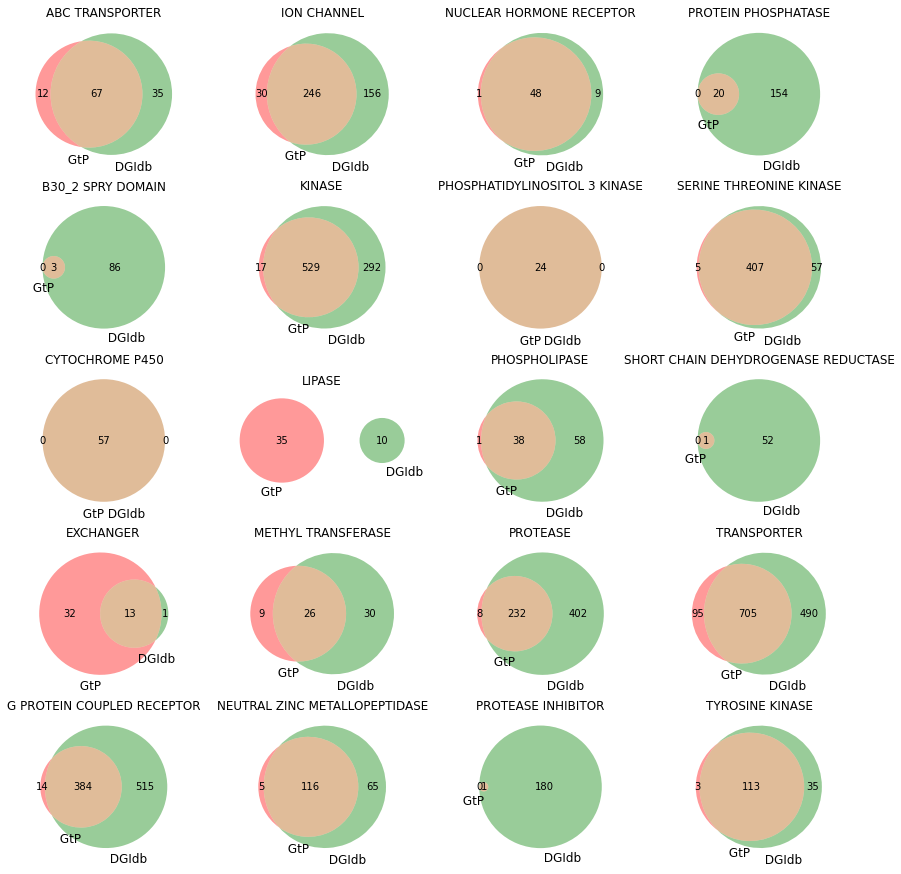

In [16]:
def intersect_values(a,b,c):
    return c-b,c-a,abs(c-a-b)
figure, axes = plt.subplots(5,4)
figure.set_size_inches(15,15)
figure.set_dpi(300)
for i, category in enumerate(final_categories):
    x = intersect_values(gtp_gene_counts[i],
                         dgi_gene_counts[i],total_gene_counts[i])
    venn2(x, (' GtP ',' DGIdb '), ax=axes[i%5][i//5])
    axes[i%5][i//5].set_title(category)
plt.show()

It may be worth double-checking the lipase group before going any further.

In [17]:
for family in dgidb_reverse_map['LIPASE']:
    print(family)

Phosphatidylcholine-specific phospholipase D
3.1.1.- Carboxylic Ester Hydrolases
Phospholipase A<sub>2</sub>
Phosphoinositide-specific phospholipase C


It looks like these are obvious lipase families, except for 3.1.1. Let's review the genes in that family.

In [18]:
for gene in family_members['3.1.1.- Carboxylic Ester Hydrolases']:
    print(gene)

ASPG
LIPF


It checks out. [ASPG](http://www.genecards.org/cgi-bin/carddisp.pl?gene=ASPG) and [LIPF](http://www.genecards.org/cgi-bin/carddisp.pl?gene=LIPF) both exhibit lipase activity. Let's move on and investigate the overall gene category size distribution, to use for identifying new gene category candidates.

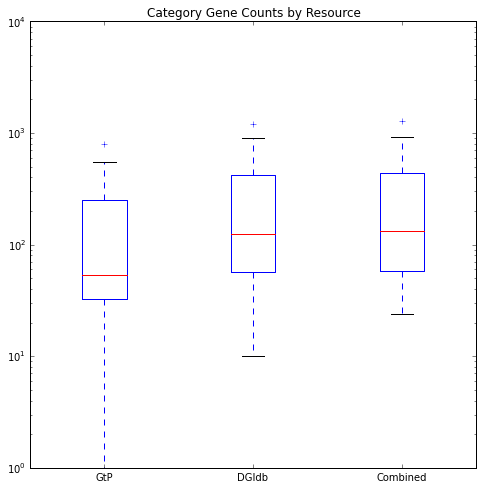

In [19]:
figure = plt.figure(figsize=(8,8),dpi=300)
plt.boxplot([gtp_gene_counts,dgi_gene_counts,total_gene_counts], 
            labels=['GtP','DGIdb','Combined'])
plt.yscale('log')
plt.title('Category Gene Counts by Resource')
plt.show()

It appears that the majority of the DGIdb categories have at least 30 genes. While evaluating new categories, we should select those that have at least as many.

In [20]:
remainder = [ family for family in family_members if family not in dgidb_category_map ]
fstring = '{0:5} {1}'
header = fstring.format('Count', 'Family')
print(header)
print('=' * len(header))
for family in sorted(remainder):
    if len(family_members[family]) >= 30:
        print(fstring.format(len(family_members[family]),family))

Count Family
   91 Class A Orphans
   30 Tumour necrosis factor (TNF) receptor family
  241 catalytic_receptor [type]
 1140 enzyme [type]
  110 other_protein [type]


Of these, the [type] values are too broad, and the [Class A Orphans](http://www.guidetopharmacology.org/GRAC/FamilyDisplayForward?familyId=16) are a collection of otherwise unclassified Rhodopsin-like GPCRs. Drugs that promote TNF to TNFR binding may be useful, making the TNFR category worth investigating further as a potential addition.

Reporting
===
We can now update the records from our initial file to include the new category mapping, omitting records with no categorical map.

In [21]:
out_fields = ['Target id', 
              'Target name', 
              'Family name', 
              'Family id',
              'Type',
              'HGNC symbol',
              'HGNC id',
              'HGNC name',
              'Human nucleotide RefSeq',
              'Human protein RefSeq',
              'Human SwissProt',
              'Human Entrez Gene',
              'Gene Category'
              ]

with open('targets_and_families.4_mar.2015.csv') as csvinfile:
    in_csv = csv.DictReader(csvinfile)
    with open('targets_and_families.mapped.4_mar_2015.tsv', 'w') as tsvoutfile:
        out_tsv = csv.DictWriter(tsvoutfile, out_fields, delimiter='\t')
        out_tsv.writeheader()
        for row in in_csv:
            family = row['Family name']
            if family not in dgidb_category_map:
                continue
            row['Gene Category'] = '|'.join(dgidb_category_map[family])
            out_tsv.writerow({ k: row[k] for k in row if k in out_fields })

Conclusion
===
Name and gene member mapping from GtP to DGIdb incorporated approximately 80% of all genes and families at least once. TNF Receptors were identified as a potential novel category for DGIdb by size inclusion, although clinical importance of this group is unknown by me. The mapped targets from GtP successfully imported into a development instance of DGIdb.